In [1]:
# Import several packages that will be used throughout

# numeric packages
import numpy as np
import scipy
import scipy.io
import pandas as pd

# filesystem and OS
import sys, os, time
import glob

# images
import skimage
import skimage
import skimage.io

# plotting
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

In [2]:
from IPython import parallel

rc = parallel.Client()
all_engines = rc[:]
lbv = rc.load_balanced_view()

print len(all_engines)

48


In [3]:
%%px --local

def initialize_matrix(L, nseeds=1):
    M = np.zeros((L,L))
    if nseeds > 1:
        ivec = np.random.randint(0, L, nseeds)
        jvec = np.random.randint(0, L, nseeds)
        M[ivec,jvec] = 1
    else:
        M[L/2,L/2] = 1
    return M

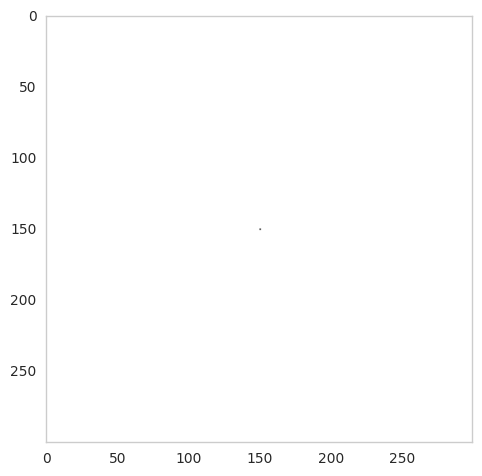

In [4]:
L = 300 # size of the inizial matrix
M0 = initialize_matrix(L, 1)
plt.imshow(M0)

In [28]:
%%px --local

from scipy.ndimage.morphology import distance_transform_cdt

def ribsky_model_iteration(M, g):
    L = M.shape[0]
    # change D to Euclidean! not available in SciPy 0.19??
    D = distance_transform_cdt(M==0, metric="taxicab") 
    mask = M==1
    D = D ** (-g)
    D[mask] = 0
    norm = D[M<1].sum()
    D[M<1] = D[M<1]/float(norm)
    R = np.random.random((L,L))
    M[R<D] = 1
    return M

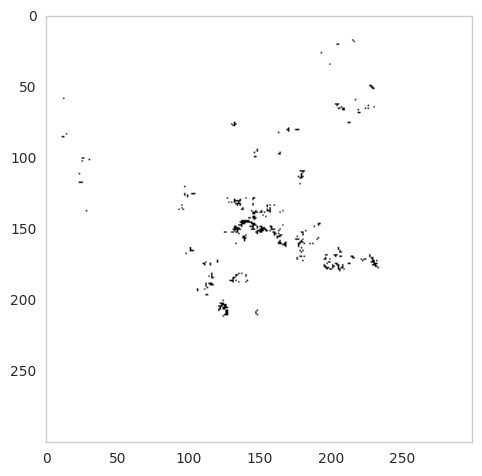

In [6]:
M = M0.copy()
for i in range(500):
    M = ribsky_model_iteration(M, 2.2)
    
plt.imshow(M)

In [7]:
%%px --local

from skimage import morphology

def compute_patch_areas(M):
    mask = morphology.label(M)
    areas = []
    for i in np.arange(1,mask.max()):
        areas.append((i,(mask==i).sum()))
    areas.sort(key=lambda x: x[1], reverse=True)
    return areas, mask

In [8]:
areas = compute_patch_areas(M)

In [35]:
%%px --local

def updated_ribsky_model(Mu0, Mr0, gu, gr, Ue, Ur, T, TRE, niter=1):
    Mu = Mu0.copy()
    Mr = Mr0.copy()
    L = Mu.shape[0]
    M_dict = {}
    for t in range(niter):
        for _ in range(Ue):
            Mu = ribsky_model_iteration(Mu, gu)
        for _ in range(Ur):
            Mr = ribsky_model_iteration(Mr, gr)
            
        # transfer rural to urban 
        areas_r, mask = compute_patch_areas(Mr)
        to_urban= [x[0] for x in areas_r if x[1]>TRE]
        for label in to_urban:
            Mu[mask==label] = Mu[mask==label] + Mr[mask==label]
            Mr[mask==label] = 0
            
        # add rural and urban together
        M = (Mu + Mr > 0).astype(int)
        
        # save snapshots
        M_dict[t] = M

        # terminate if map is filled above threshold
        q = M.sum() / float(L**2)
        if q > T:
            break

    return M, M_dict      

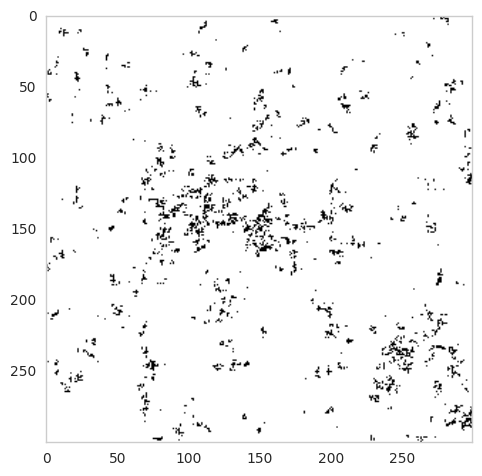

In [36]:
Mu0 = initialize_matrix(L, 1)
Mr0 = initialize_matrix(L, 100)
gu = 2.0
gr = 3.2
Ue = 70
Ur = 100-Ue
T = 0.1
TRE=5 # threshold of area from rural to urban NOW IN NUMBER OF PIXEL

M, M_dict = updated_ribsky_model(Mu0, Mr0, gu, gr, Ue, Ur, T, TRE, niter=30)

plt.imshow(M)

(-0.5, 299.5, 299.5, -0.5)

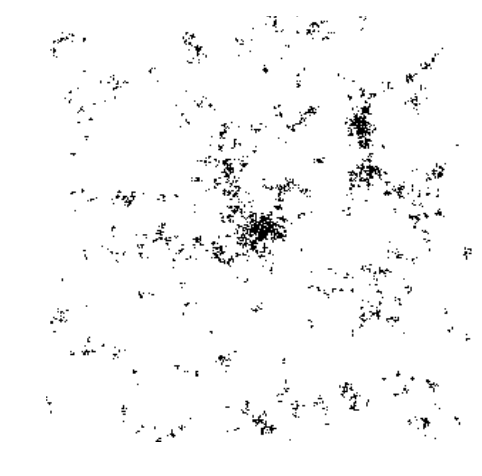

In [60]:
Mu0 = initialize_matrix(L, 1)
Mr0 = initialize_matrix(L, 100)
gu = 2.4
gr = 2.4
Ue = 65
Ur = 100-Ue
T = 0.18
TRE=5 # threshold of area from rural to urban NOW IN NUMBER OF PIXEL

# Hu65_Gu2.40_Gr2.40_T0.18

M, M_dict = updated_ribsky_model(Mu0, Mr0, gu, gr, Ue, Ur, T, TRE, niter=30)

plt.imshow(M)
plt.axis("off")

In [ ]:
%%timeit
M = updated_ribsky_model(Mu0, Mr0, gu, gr, Ue, Ur, T, TRE, niter=30)

# Generate samples

In [12]:
Hu_vec = np.linspace(40, 90, 5)
Hr_vec = 100 - Hu_vec
Gu =[2,2.2,2.4,2.6,2.8,3,3.2,3.4,3.6,3.8] # Urban gamma
Gr =[2,2.2,2.4,2.6,2.8,3,3.2,3.4,3.6,3.8] # Rural gamma
T_vec = np.linspace(0.01, 0.4, 10)        # threshold of built land
N_SIM = 1

params_vec = np.array(np.meshgrid(Hu_vec, Gu, Gr, T_vec, range(N_SIM)))\
                .T.reshape((-1,5))

params_vec.shape

(5000, 5)

In [13]:
%%px --local 
import os
import numpy as np
import skimage
import skimage.io

In [50]:
savepath = "/home/adalbert/data/world-cities/simulations/"

def generate_samples(params, savepath=savepath):
    Ue, Gu, Gr, T, n = params
    Ue = int(Ue)
    Ur = 100 - Ue
    nseed = 100
    max_niter = 100
    L = 300  # map size
    TRE=5 # threshold of area from rural to urban NOW IN NUMBER OF PIXEL
    iter_save = 3
    
    basedir = savepath + \
        "/Hu%d_Gu%2.2f_Gr%2.2f_T%2.2f"%(Ue, Gu, Gr, T)
    if not os.path.exists(basedir):
        os.makedirs(basedir)

    Mu0 = initialize_matrix(L, 1)
    Mr0 = initialize_matrix(L, nseed)
    M, M_dict = updated_ribsky_model(Mu0, Mr0, Gu, Gr, Ue, Ur, T, TRE, \
                             niter=max_niter)

    if iter_save is not None:
        ret = []
        for it, M in M_dict.iteritems():
            if it % iter_save == 0:
                filename = "%s/%d_iter%d.png"%(basedir,n,it)
                skimage.io.imsave(filename, M)
                ret.append(filename)
    else:
        filename = "%s/%d_iter%d.png"%(basedir,n,max(M_dict.keys()))
        skimage.io.imsave(filename, M)
        ret = [filename]
        
    return ret

In [48]:
generate_samples(params_vec[0], iter_save=3)

['/home/adalbert/data/world-cities/simulations//Hu40_Gu2.00_Gr2.00_T0.01/0_iter0.png',
 '/home/adalbert/data/world-cities/simulations//Hu40_Gu2.00_Gr2.00_T0.01/0_iter3.png',
 '/home/adalbert/data/world-cities/simulations//Hu40_Gu2.00_Gr2.00_T0.01/0_iter6.png']

In [55]:
amr = lbv.map_async(generate_samples, params_vec)

In [56]:
amr.progress

268

In [ ]:
amr.result()

In [18]:
params_vec[:10].shape

(10, 5)